In [12]:
import torch
import torchvision
import torchvision.models as models
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc; gc.enable()
import pandas as pd
from torch.utils.data import Dataset
import tensorflow as tf
from tensorflow import keras
from torchvision import transforms

In [85]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
# keras imports
from keras.models import Model
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Input
# other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
import numpy as np
import glob
import h5py
import json
import datetime
import time

In [96]:
from tensorflow.keras.callbacks import Callback
# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB5.h5'
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / batch_size))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

In [97]:
train_dir = '/Users/flatironschool/Documents/Kaggle/Kaggle-DR-detection/data/'
img_dir = train_dir + 'train/'

In [98]:
train_df = pd.read_csv(train_dir+'dr15labels_2.csv')
train_df_2 = pd.read_csv('/Users/flatironschool/Documents/Kaggle/Kaggle-DR-detection/drlabels.csv')

In [99]:
sub = train_df.sample(frac = 0.2)
sub2 = train_df_2.sample(frac = 0.2)
subs = pd.concat([sub,sub2])
val_sub = train_df.sample(frac = 0.05)
val_sub2 = train_df_2.sample(frac = 0.05)
val_subs = pd.concat([val_sub,val_sub2])

In [100]:
subs.columns = ['id_code','diagnosis']
subs['diagnosis'] = subs['diagnosis'].astype(str)
for ind in subs.index:
    diag = subs['diagnosis'][ind]
    subs['id_code'][ind] = img_dir+ str(diag) +'/'+ subs['id_code'][ind] +'.png'

In [101]:
val_subs.columns = ['id_code','diagnosis']
val_subs['diagnosis'] = val_subs['diagnosis'].astype(str)
for ind in val_subs.index:
    diag = val_subs['diagnosis'][ind]
    val_subs['id_code'][ind] = img_dir+ str(diag) +'/'+ val_subs['id_code'][ind] +'.png'

In [92]:
xception = keras.applications.Xception(include_top = False, weights = 'imagenet')

In [93]:
input_shape = xception.output_shape
out = xception.output
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(512, activation='relu')(out)
total_classes = 5
predictions = keras.layers.Dense(total_classes, activation='softmax')(out)

model = keras.models.Model(inputs=xception.input, outputs=predictions)

In [94]:
set_trainable = False
cnt = 0
for layer in model.layers:
    if cnt>130:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    cnt+=1

In [105]:
# training_generator = BalancedBatchGenerator(X_train, y_train,
#                                                 batch_size=1000,
#                                                 random_state=42)
#     model.fit_generator(generator=training_generator, epochs=5, verbose=1)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
datagen = keras.preprocessing.image.ImageDataGenerator()
batch_size = 32
train_steps_per_epoch = len(subs)//batch_size
adm = tf.keras.optimizers.Adam(lr = 0.0001)

train_generator = datagen.flow_from_dataframe(subs, 
                                              x_col = 'id_code', 
                                              y_col = 'diagnosis',
                                              target_size = (224,224),
                                              batch_size = batch_size,
                                              class_mode ='categorical') 
val_generator = datagen.flow_from_dataframe(val_subs, 
                                            x_col='id_code', 
                                            y_col='diagnosis',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=3, 
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

model.compile(optimizer = adm, loss = 'categorical_crossentropy')
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch, 
                              validation_data=val_generator,
                              validation_steps = val_generator.samples // batch_size,
                              epochs=150, verbose=1, callbacks=[kappa_metrics, es, rlr])

Found 5077 validated image filenames belonging to 5 classes.
Found 1418 validated image filenames belonging to 5 classes.


/Users/flatironschool/.local/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2087 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/Users/flatironschool/.local/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 373 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/150
45/45 [==============================] - 232s 5s/step - loss: 9.8456
val_kappa: 0.2392
Validation Kappa has improved. Saving model.
159/159 [==============================] - 1557s 10s/step - loss: 0.5337 - val_loss: 9.8456
Epoch 2/150
45/45 [==============================] - 234s 5s/step - loss: 9.7962
val_kappa: 0.2392
Validation Kappa has improved. Saving model.
159/159 [==============================] - 1502s 9s/step - loss: 0.5293 - val_loss: 9.7962
Epoch 3/150
45/45 [==============================] - 227s 5s/step - loss: 9.8221
val_kappa: 0.2392
Validation Kappa has improved. Saving model.
159/159 [==============================] - 1476s 9s/step - loss: 0.5159 - val_loss: 9.8221
Epoch 4/150
45/45 [==============================] - 289s 6s/step - loss: 9.7969
val_kappa: 0.2392
Validation Kappa has improved. Saving model.
159/159 [==============================] - 2929s 18s/step - loss: 0.5078 - val_loss: 9.7969
Epoch 5/150
45/45 [==============================] - 271s 

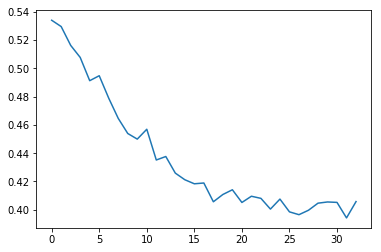

In [106]:
plt.plot(history.history['loss'])
plt.savefig('loss_miniXception')

In [107]:
model_json = model.to_json()
with open("miniXception.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("miniXception.h5")
print("Saved model to disk")

Saved model to disk


In [23]:
get_last_pretrained_layer = keras.backend.function([model.layers[0].input],
                                  [model.layers[131].output])

In [27]:
train_features = np.zeros(shape=(21972, 7, 7, 2048))
train_labels = np.zeros(shape=(21972,5))

In [30]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = get_last_pretrained_layer(inputs_batch)[0]
    train_features[i : i + len(inputs_batch)] = features_batch
    train_labels[i : i +len(inputs_batch)] = labels_batch
    i += len(inputs_batch)
    print(i)
    if i+2 > len(train_features):
        break
         
train_features = np.reshape(train_features, (21972, 7 * 7 * 2048))

32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
6624

In [33]:
import gc; gc.enable()
del model, xception, train_generator; gc.collect()

3625

In [4]:
from sklearn.model_selection import train_test_split
feat_train, feat_test, labels_train, labels_test = train_test_split(train_features, train_labels, test_size = 0.2)

NameError: name 'train_features' is not defined

In [ ]:
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

In [32]:
from sklearn.model_selection import StratifiedKFold, KFold
import xgboost as xgb
params = {
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 5,
}

In [1]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y_train)):
    
    trn_x, trn_y = train[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    gc.collect()
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    gc.collect()
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=1500, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 250, early_stopping_rounds=100) 
    gc.collect()
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits
    gc.collect()
    
    xgbfir.saveXgbFI(clf, feature_names=trn_x.columns, OutputXlsxFile='ieee_xgbfir_%sFold.xlsx'%str(n_fold+1), MaxInteractionDepth=9, MaxHistograms=15)
    gc.collect()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    gc.collect()
    
    print('\nFold %2d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))


NameError: name 'folds' is not defined

In [3]:
X = feat_train
bleh, y = np.where(labels_train)

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(feat_test)

NameError: name 'feat_train' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
bleh, y_test = np.where(labels_test)
print(cohen_kappa_score(y_test, y_pred))